In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
import sys

import hydra
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torchaudio
import lightning.pytorch as pl
from scipy.stats import gaussian_kde
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import numpy as np


from IPython.display import Audio, display

from pathlib import Path
from egaznepy.visualize import apply_plot_style
from src.data.mocha_timit_datamodule import MTIMITDataModule
from src.models.pitch_module import PitchModule
from src.models.components.metrics import RCAMetric
from torchmetrics.classification.accuracy import Accuracy



apply_plot_style(0.9)
plt.rcParams['text.usetex'] = False

root_dir = Path(globals()['_dh'][0]).parent
print(root_dir)
import os
os.chdir(root_dir)

config_path_predict = 'logs/eval/runs/2024-07-08_14-47-15_fda_test_with_noslice/.hydra/config.yaml'
ckpt_path = 'weights/joint/2024-05-29_17-03-54/checkpoints/epoch_135.ckpt'
config_path_eval_amazon ="logs/eval/runs/2024-07-08_14-54-12_amazon_fda/.hydra/config.yaml"
config_path_eval_yaapt = 'logs/eval/runs/2024-07-08_14-55-21_yaapt_fda/.hydra/config.yaml'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/dataHDD/chsaikeerthi/2024-chirumamilla


In [8]:
config_predict = OmegaConf.load(config_path_predict)
datamodule = hydra.utils.instantiate(config_predict.data, slice_length=10, batch_size= 4)
pitch_module: PitchModule = hydra.utils.instantiate(config_predict.model)

config_eval_amazon = OmegaConf.load(config_path_eval_amazon)
datamodule_amazon = hydra.utils.instantiate(config_predict.data, slice_length=10, batch_size = 4)
amazon_module: PitchModule = hydra.utils.instantiate(config_eval_amazon.model)

config_eval_yaapt = OmegaConf.load(config_path_eval_yaapt)
datamodule_yaapt = hydra.utils.instantiate(config_predict.data, slice_length=10,batch_size = 4)
yaapt_module: PitchModule = hydra.utils.instantiate(config_eval_yaapt.model)




del config_predict.trainer.default_root_dir
del config_eval_amazon.trainer.default_root_dir
del config_eval_yaapt.trainer.default_root_dir

config_predict.trainer.limit_predict_batches = 1

trainer = hydra.utils.instantiate(config_predict.trainer) 
arr_predict = trainer.predict(model=pitch_module, datamodule=datamodule, ckpt_path=ckpt_path)
arr_eval_amazon = trainer.predict(model=amazon_module, datamodule=datamodule_amazon)
arr_eval_yaapt = trainer.predict(model=yaapt_module, datamodule=datamodule_yaapt)

/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'extractor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['extractor'])`.
/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/traine

Preparing data...
Data directory: data/
Should implement the code to check if data is already downloaded and extracted for TIMIT
Data prepared successfully.
Data folder: data/FDA_sr20
Train set length: 0
Validation set length: 0
Test set length: 100
Data set-up done successfully.


Predicting: |          | 0/? [00:00<?, ?it/s]

Preparing data...
Data directory: data/
Should implement the code to check if data is already downloaded and extracted for TIMIT
Data prepared successfully.
Data folder: data/FDA_sr20
Train set length: 0
Validation set length: 0
Test set length: 100
Data set-up done successfully.


/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:44: attribute 'encoder' removed from hparams because it cannot be pickled


Predicting: |          | 0/? [00:00<?, ?it/s]

Preparing data...
Data directory: data/
Should implement the code to check if data is already downloaded and extracted for TIMIT
Data prepared successfully.
Data folder: data/FDA_sr20
Train set length: 0
Validation set length: 0
Test set length: 100
Data set-up done successfully.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [9]:
# Extract the first 4 elements - our model

pitches_predicted = arr_predict[0][0:4]
pitches_eval_amazon = arr_eval_amazon[0][0:4]
pitches_eval_yaapt = arr_eval_yaapt[0][0:4]
print("amazon",pitches_eval_amazon.shape)
print("yaapt",pitches_eval_yaapt.shape)


# gt
corresponding_data = next(iter(datamodule.test_dataloader()))
corresponding_audio = corresponding_data[0][0:4]
pitches_gt = corresponding_data[1][0:4]
probs_gt = corresponding_data[2][0:4]
mask_gt = probs_gt > 0
pitches_gt = pitch_module.decoder.idx_pitch[pitches_gt.argmax(dim=-1)]
#pitches_gt = pitches_gt * mask_gt
pitches_predicted =pitches_predicted * mask_gt
pitches_predicted = torch.where(pitches_predicted == 0, torch.tensor(62.5), pitches_predicted)

print("pitches_shape",pitches_gt.shape)
print("probs_shape",probs_gt.shape)

amazon torch.Size([4, 400])
yaapt torch.Size([4, 400])
pitches_shape torch.Size([4, 400])
probs_shape torch.Size([4, 400])


In [10]:
rca = RCAMetric(test_mode=True)
out = rca.ret_current_rca(pitches_predicted, pitches_gt, probs_gt)

result = torch.where(torch.tensor(out), torch.tensor(40.0), torch.tensor(0))
torch.set_printoptions(threshold=torch.inf)


/tmp/ipykernel_2439340/1060482133.py:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  result = torch.where(torch.tensor(out), torch.tensor(40.0), torch.tensor(0))


pitches_pridict shape torch.Size([4, 400]) 
ground truth shape torch.Size([4, 400]) 
ground_truth min tensor(62.5000) 
ground truth max tensor(410.3947) 
predict pitched min  tensor(62.5000) 
predict pitched max  tensor(321.5530) 
pitches_eval shape torch.Size([4, 400]) 
pitches_eval min tensor(62.5000) 
pitches_eval max tensor(356.9927) 
pitches_eval shape torch.Size([4, 400]) 
pitches_eval min tensor(62.5000) 
pitches_eval max tensor(344.7654) 
result_max tensor(40.) 
result_min tensor(0.)


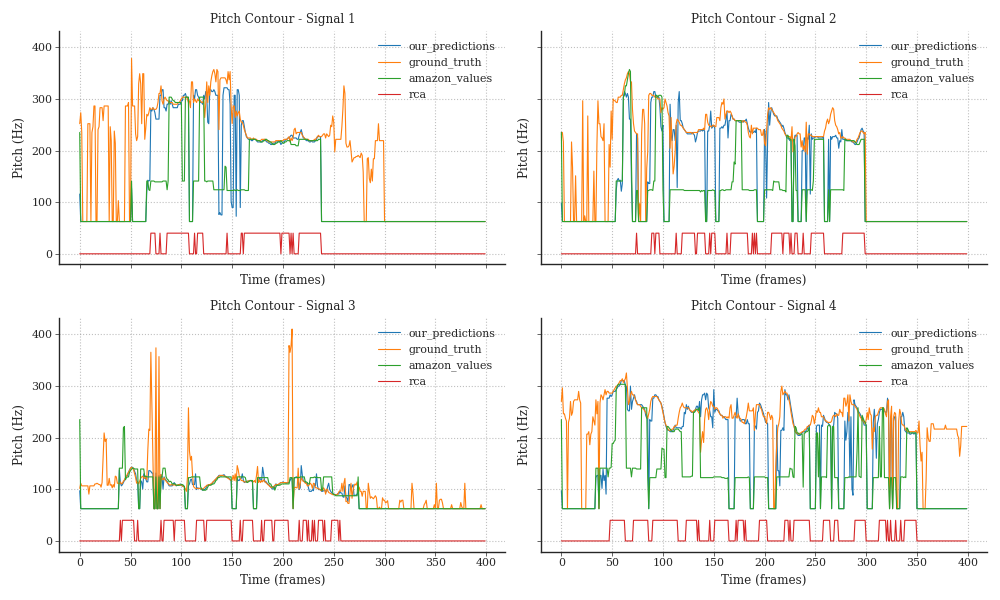

In [11]:
def plot_pitch_line_subplots(**model_pitches):
    num_signals = len(list(model_pitches.values())[0])
    fig, axs = plt.subplots(num_signals//2, num_signals//2, figsize=(5*num_signals//2, 3*num_signals//2), sharex=True, sharey=True)
    axs = axs.flatten()
    
    for model_name, pitches in model_pitches.items():
        for i, pitch in enumerate(pitches):
            axs[i].plot(pitch, label=model_name)
            axs[i].set_title(f'Pitch Contour - Signal {i + 1}')
            axs[i].set_xlabel('Time (frames)')
            axs[i].set_ylabel('Pitch (Hz)')
            axs[i].grid(True)
            axs[i].legend()      
    
    plt.tight_layout()
    plt.show()


print("pitches_pridict shape",pitches_predicted.shape,
      "\nground truth shape" ,pitches_gt.shape,
      "\nground_truth min", pitches_gt.min(),
      "\nground truth max", pitches_gt.max(),
      "\npredict pitched min " ,pitches_predicted.min(),
      "\npredict pitched max ", pitches_predicted.max(),
      "\npitches_eval shape",pitches_eval_amazon.shape,
      "\npitches_eval min",pitches_eval_amazon.min(),
      "\npitches_eval max",pitches_eval_amazon.max(),
      "\npitches_eval shape",pitches_eval_yaapt.shape,
      "\npitches_eval min",pitches_eval_yaapt.min(),
      "\npitches_eval max",pitches_eval_yaapt.max(),
      "\nresult_max",result.max(),
        "\nresult_min",result.min()
      )


# Plotting each of the first 4 elements
#fig, axs = plt.subplots(4, 1, figsize=(10, 8))
plot_pitch_line_subplots(our_predictions=pitches_predicted, ground_truth=pitches_gt, amazon_values=pitches_eval_amazon, rca=result)


for audio in corresponding_audio:
    display(Audio(audio.squeeze().numpy(), rate=16000))
    

pitches_pridict shape torch.Size([4, 400]) 
ground truth shape torch.Size([4, 400]) 
ground_truth min tensor(62.5000) 
ground truth max tensor(410.3947) 
predict pitched min  tensor(62.5000) 
predict pitched max  tensor(321.5530) 
pitches_eval shape torch.Size([4, 400]) 
pitches_eval min tensor(62.5000) 
pitches_eval max tensor(356.9927) 
pitches_eval shape torch.Size([4, 400]) 
pitches_eval min tensor(62.5000) 
pitches_eval max tensor(344.7654) 
result_max tensor(40.) 
result_min tensor(0.)


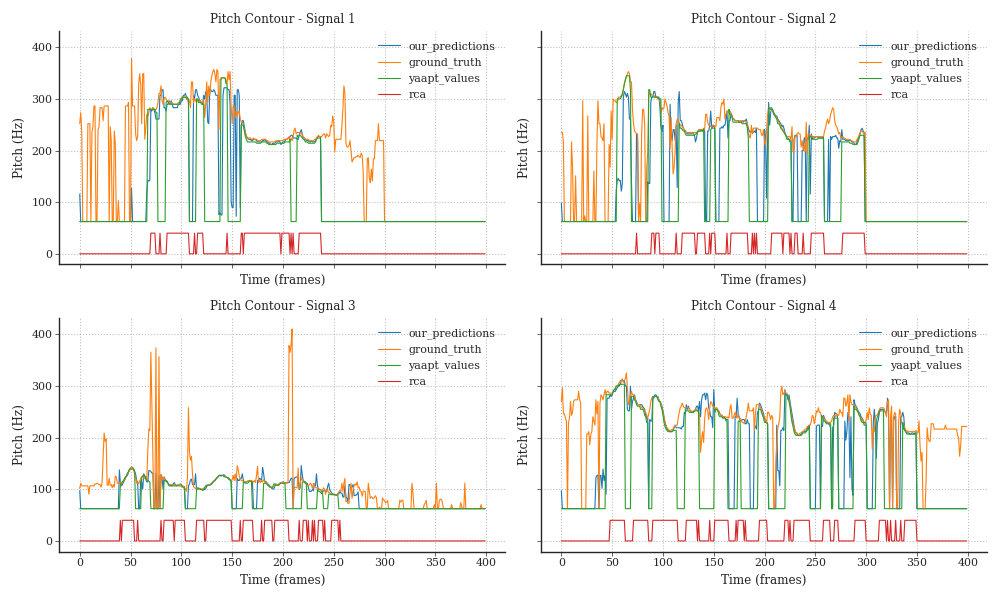

In [12]:
def plot_pitch_line_subplots(**model_pitches):
    num_signals = len(list(model_pitches.values())[0])
    fig, axs = plt.subplots(num_signals//2, num_signals//2, figsize=(5*num_signals//2, 3*num_signals//2), sharex=True, sharey=True)
    axs = axs.flatten()
    
    for model_name, pitches in model_pitches.items():
        for i, pitch in enumerate(pitches):
            axs[i].plot(pitch, label=model_name)
            axs[i].set_title(f'Pitch Contour - Signal {i + 1}')
            axs[i].set_xlabel('Time (frames)')
            axs[i].set_ylabel('Pitch (Hz)')
            axs[i].grid(True)
            axs[i].legend()      
    
    plt.tight_layout()
    plt.show()


print("pitches_pridict shape",pitches_predicted.shape,
      "\nground truth shape" ,pitches_gt.shape,
      "\nground_truth min", pitches_gt.min(),
      "\nground truth max", pitches_gt.max(),
      "\npredict pitched min " ,pitches_predicted.min(),
      "\npredict pitched max ", pitches_predicted.max(),
      "\npitches_eval shape",pitches_eval_amazon.shape,
      "\npitches_eval min",pitches_eval_amazon.min(),
      "\npitches_eval max",pitches_eval_amazon.max(),
      "\npitches_eval shape",pitches_eval_yaapt.shape,
      "\npitches_eval min",pitches_eval_yaapt.min(),
      "\npitches_eval max",pitches_eval_yaapt.max(),
      "\nresult_max",result.max(),
        "\nresult_min",result.min()
      )


# Plotting each of the first 4 elements
#fig, axs = plt.subplots(4, 1, figsize=(10, 8))
plot_pitch_line_subplots(our_predictions=pitches_predicted, ground_truth=pitches_gt, yaapt_values=pitches_eval_yaapt, rca=result)


for audio in corresponding_audio:
    display(Audio(audio.squeeze().numpy(), rate=16000))
    